# COURS: Deep learning
## MUNDIAPOLIS - MDS

In [32]:
# import libraries
import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [33]:
df = pd.read_csv('/content/laptop_price.csv', encoding='latin1')

In [34]:
df.tail(3)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.0
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.0
1302,1320,Asus,X553SA-XX031T (N3050/4GB/500GB/W10),Notebook,15.6,1366x768,Intel Celeron Dual Core N3050 1.6GHz,4GB,500GB HDD,Intel HD Graphics,Windows 10,2.2kg,369.0


In [35]:
df.shape

(1303, 13)

In [36]:
df.duplicated().sum()

np.int64(0)

In [37]:
df.nunique()

,0
laptop_ID,1303
Company,19
Product,618
TypeName,6
Inches,18
ScreenResolution,40
Cpu,118
Ram,9
Memory,39
Gpu,110


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [39]:
df.describe(include='O').T

,count,unique,top,freq
Company,1303,19,Dell,297
Product,1303,618,XPS 13,30
TypeName,1303,6,Notebook,727
ScreenResolution,1303,40,Full HD 1920x1080,507
Cpu,1303,118,Intel Core i5 7200U 2.5GHz,190
Ram,1303,9,8GB,619
Memory,1303,39,256GB SSD,412
Gpu,1303,110,Intel HD Graphics 620,281
OpSys,1303,9,Windows 10,1072
Weight,1303,179,2.2kg,121


# **Regression par réseau de neuronnes**

In [40]:
df.head(1)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69


In [41]:
# Extraire les trois composantes du CPU
df['Cpu_brand'] = df['Cpu'].apply(lambda x: x.split()[0])

df['Cpu_type'] = df['Cpu'].apply(
    lambda x: ' '.join(x.split()[1:-1])
)

df['Cpu_speed_GHz'] = df['Cpu'].apply(
    lambda x: x.split()[-1].replace('GHz', '')
).astype(float)

# Supprimer l'ancienne colonne 'Cpu'
df = df.drop(columns=['Cpu'])

In [42]:
# Séparer la colonne GPU en deux parties
df['Gpu_brand'] = df['Gpu'].apply(lambda x: x.split()[0])
df['Gpu_model'] = df['Gpu'].apply(lambda x: ' '.join(x.split()[1:]))

# Supprimer la colonne originale
df = df.drop(columns=['Gpu'])

In [43]:
# Nettoyer la colonne Ram et la convertir en numérique
df['Ram'] = df['Ram'].str.replace('GB', '', regex=False).astype(int)
# Nettoyer la colonne Weight et la convertir en numérique
df['Weight'] = df['Weight'].str.replace('kg', '', regex=False).astype(float)

In [44]:
def parse_memory_complex(mem):
    """
    Convertit une chaîne Memory complexe en total GB et liste des types
    ex: "512GB SSD + 1TB HDD" → (1536, ['SSD','HDD'])
    """
    # Trouver toutes les occurrences de taille + unité + type
    pattern = r'(\d+)(GB|TB)\s*(\w+)'
    matches = re.findall(pattern, mem)

    total_size = 0
    types = []
    for size, unit, mtype in matches:
        size = int(size)
        if unit == 'TB':
            size = size * 1024  # convertir TB en GB
        total_size += size
        types.append(mtype)

    types_str = '+'.join(types)  # concaténer les types
    return pd.Series([total_size, types_str])

# Appliquer la fonction
df[['Memory_size_GB', 'Memory_type']] = df['Memory'].apply(parse_memory_complex)

# Supprimer la colonne originale
df = df.drop(columns=['Memory'])

In [45]:
# Extraire uniquement le total de pixels
def extract_pixels(res):
    match = re.search(r'(\d+)x(\d+)', res)
    if match:
        width = int(match.group(1))
        height = int(match.group(2))
        return width * height
    else:
        return None

# Appliquer la fonction
df['Screen_pixels'] = df['ScreenResolution'].apply(extract_pixels)

# Supprimer la colonne originale
df = df.drop(columns=['ScreenResolution'])

In [46]:
# Vérification
df.head(1)

,laptop_ID,Company,Product,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Cpu_brand,Cpu_type,Cpu_speed_GHz,Gpu_brand,Gpu_model,Memory_size_GB,Memory_type,Screen_pixels
0,1,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Intel,Core i5,2.3,Intel,Iris Plus Graphics 640,128,SSD,4096000


In [47]:
X = df.drop(columns=['laptop_ID','Price_euros'])
y = df['Price_euros']

In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company         1303 non-null   object 
 1   Product         1303 non-null   object 
 2   TypeName        1303 non-null   object 
 3   Inches          1303 non-null   float64
 4   Ram             1303 non-null   int64  
 5   OpSys           1303 non-null   object 
 6   Weight          1303 non-null   float64
 7   Cpu_brand       1303 non-null   object 
 8   Cpu_type        1303 non-null   object 
 9   Cpu_speed_GHz   1303 non-null   float64
 10  Gpu_brand       1303 non-null   object 
 11  Gpu_model       1303 non-null   object 
 12  Memory_size_GB  1303 non-null   int64  
 13  Memory_type     1303 non-null   object 
 14  Screen_pixels   1303 non-null   int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 152.8+ KB


In [49]:
# Encodage one-hot des colonnes non-numériques
X = pd.get_dummies(X, drop_first=True)

In [50]:
X.head()

,Inches,Ram,Weight,Cpu_speed_GHz,Memory_size_GB,Screen_pixels,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,...,Gpu_model_Radeon RX 580,Gpu_model_UHD Graphics 620,Memory_type_Flash+HDD,Memory_type_HDD,Memory_type_HDD+HDD,Memory_type_Hybrid,Memory_type_SSD,Memory_type_SSD+HDD,Memory_type_SSD+Hybrid,Memory_type_SSD+SSD
0,13.3,8,1.37,2.3,128,4096000,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,13.3,8,1.34,1.8,128,1296000,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,15.6,8,1.86,2.5,256,2073600,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,15.4,16,1.83,2.7,512,5184000,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,13.3,8,1.37,3.1,256,4096000,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [51]:
# Conserver les noms de features pour debug
feature_names = X.columns.tolist()
print("X shape après encodage:", X.shape)
print("Nombre de features:", len(feature_names))

X shape après encodage: (1303, 864)
Nombre de features: 864


In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Columns: 864 entries, Inches to Memory_type_SSD+SSD
dtypes: bool(858), float64(3), int64(3)
memory usage: 1.1 MB


# Split & normalisation

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values.astype(np.float32), test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Conversion en tenseurs PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

X_train_t.shape, y_train_t.shape


(torch.Size([1042, 864]), torch.Size([1042, 1]))

In [60]:
X_train_t

tensor([[ 0.4280, -0.8574, -0.2485,  ..., -0.4400, -0.0310, -0.0537],
        [ 0.4280, -0.8574, -0.0385,  ..., -0.4400, -0.0310, -0.0537],
        [ 0.4280, -0.4650,  0.2464,  ..., -0.4400, -0.0310, -0.0537],
        ...,
        [ 0.4280, -0.4650,  0.0214,  ..., -0.4400, -0.0310, -0.0537],
        [ 0.4280, -0.0727,  0.4113,  ..., -0.4400, -0.0310, -0.0537],
        [-3.3856, -0.8574, -2.0029,  ..., -0.4400, -0.0310, -0.0537]])

# Modèle PyTorch (réseau de neurones simple)

In [61]:
n_features = X_train_t.shape[1]

model = nn.Sequential(
    nn.Linear(n_features, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)  # Sortie: prix (régression)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

sum(p.numel() for p in model.parameters()), model


(28225,
 Sequential(
   (0): Linear(in_features=864, out_features=32, bias=True)
   (1): ReLU()
   (2): Linear(in_features=32, out_features=16, bias=True)
   (3): ReLU()
   (4): Linear(in_features=16, out_features=1, bias=True)
 ))

# Entraînement

Epoch 050/300 - MSE: 22671.6509
Epoch 100/300 - MSE: 11327.8333
Epoch 150/300 - MSE: 9638.5960
Epoch 200/300 - MSE: 8757.7686
Epoch 250/300 - MSE: 7767.7780
Epoch 300/300 - MSE: 7246.8665


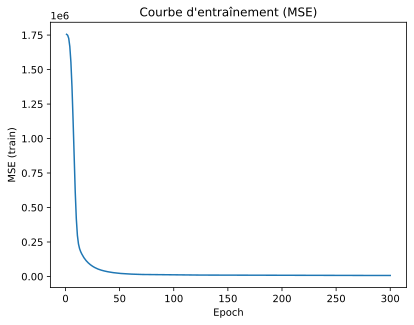

In [62]:
epochs = 300
train_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d}/{epochs} - MSE: {epoch_loss:.4f}")

# Visualisation de la courbe de perte (MSE)
plt.figure()
plt.plot(range(1, epochs+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (train)")
plt.title("Courbe d'entraînement (MSE)")
plt.show()

# Évaluation

MSE: 200732.2344 | RMSE: 448.0315 | MAE: 308.6990


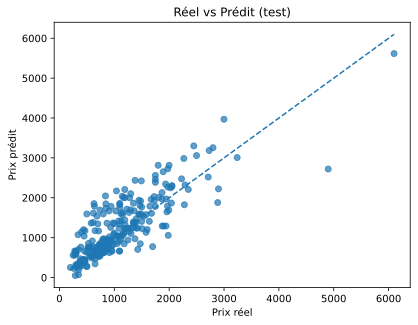

In [63]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).numpy().reshape(-1)

# Métriques basiques
mse = np.mean((y_pred_test - y_test)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred_test - y_test))

print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

# Visualisation: y_true vs y_pred
plt.figure()
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.xlabel("Prix réel")
plt.ylabel("Prix prédit")
plt.title("Réel vs Prédit (test)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--')
plt.show()


# Prédire pour une nouvelle observation

In [64]:
# Exemple: prendre une ligne du test et prédire
ex = X_test[:1]
ex_t = torch.tensor(ex, dtype=torch.float32)
with torch.no_grad():
    pred_price = model(ex_t).numpy().reshape(-1)[0]
print("Prix prédit pour un exemple du test:", float(pred_price))


Prix prédit pour un exemple du test: 1958.7086181640625
